In [2]:
""" Latent Semantic Analysis

This takes in book titles. the purpose of LSA here is to represent each term (word) 
in the corpus (the total collection of book titles), as a projection onto documents. 
The intuition here is that a word appears in books of many type, for example sex would
appear in medical books, romantic books, and anatomy books. So the 'meaning' of sex
is then represented by a linear combination of all these different books.

Also to note here is that unlike the sentiment analysis program where the features were
frequencies of the terms in the review (whose sum is normalized to 1.), here the features are
indicators, i.e. 'does this word appear in the book title or not?'

"""

" Latent Semantic Analysis\n\nThis takes in book titles. the purpose of LSA here is to represent each term (word) \nin the corpus (the total collection of book titles), as a projection onto documents. \nThe intuition here is that a word appears in books of many type, for example sex would\nappear in medical books, romantic books, and anatomy books. So the 'meaning' of sex\nis then represented by a linear combination of all these different books.\n\nAlso to note here is that unlike the sentiment analysis program where the features were\nfrequencies of the terms in the review (whose sum is normalized to 1.), here the features are\nindicators, i.e. 'does this word appear in the book title or not?'\n\n"

In [40]:
# use this to make matplotlib draw within the notebook, and not launch a new window
%matplotlib notebook 
import nltk
import numpy as np
from matplotlib import pyplot as plt
import sklearn # for SVD
import pdb

In [ ]:
""" Order of Operations
1. Read the Data,Stopwords
2. Preprocessing the Data:1. lowercase, Tokenize, lemmatize,  remove stop words
                          2. make vocabulary
                          3. convert to numeric data

3. Fit using SVD
4. Visualize the results
"""

In [17]:
"""
Get the data
"""

all_titles = [w.rstrip() for w in open('all_book_titles.txt','r')] # the for ..  in open(...) reads in lines...i.e. till the next new line
                                                                   # rstrip removes the '\n' from the end
# TODO see what happens without rstrip
""" TODO try this piece of code
    with open('all_book_titles.txt','r') as f:
            t = f.read()
            print type(t),len(t)
"""
stop_words = set([w.rstrip() for w in open('stopwords.txt','r')]) # set datatype makes sure only unique entries
                                                                  # are the in stop_words
print stop_words
# we want to add some stop words to this list, according the video. the set allows a union operation to happen
stop_words = stop_words.union(['introduction', 'edition', 'series', 'application',
    'approach', 'card', 'access', 'package', 'plus', 'etext',
    'brief', 'vol', 'fundamental', 'guide', 'essential', 'printed',
    'third', 'second', 'fourth'])


set(['all', 'pointing', 'four', 'go', 'oldest', 'seemed', 'whose', 'certainly', 'presents', 'to', 'asking', 'those', 'under', 'far', 'every', 'presented', 'did', 'turns', 'large', 'p', 'small', 'parted', 'smaller', 'says', 'second', 'further', 'nnnnnsary', 'even', 'what', 'anywhere', 'above', 'new', 'ever', 'full', 'men', 'here', 'youngest', 'let', 'groups', 'others', 'alone', 'along', 'great', 'k', 'put', 'everybody', 'use', 'from', 'working', 'yyyyyyyung', 'two', 'next', 'almost', 'therefore', 'taken', 'until', 'today', 'more', 'knows', 'clearly', 'becomes', 'it', 'downing', 'everywhere', 'known', 'cases', 'must', 'me', 'states', 'room', 'f', 'work', 'itself', 'can', 'mr', 'making', 'my', 'numbers', 'give', 'high', 'something', 'want', 'needs', 'end', 'turn', 'rather', 'how', 'y', 'may', 'after', 'such', 'man', 'a', 'q', 'so', 'keeps', 'order', 'furthering', 'over', 'years', 'ended', 'through', 'still', 'its', 'before', 'group', 'somewhere', 'interesting', 'better', 'differently', 'm

In [44]:
wordnet_lemmatizer = nltk.stem.WordNetLemmatizer()
""" Make the tokenization code """
def tokenizer(txt):
    txt_lower = txt.lower() # make lower case
    tokens = nltk.tokenize.word_tokenize(txt_lower) # make tokens TODO how is this different from split
                                                    # try this: tokens = txt_lower.split()
    
    tokens = [w for w in tokens if len(w) > 2] # remove the short words
    stemmed = [wordnet_lemmatizer.lemmatize(w) for w in tokens] # lemmatize, i.e. convert to the root word
    pruned = [w for w in tokens if w not in stop_words] # remove the stop words
    # This is extra for all_book_titles.txt , we remove stuff like 1st edition, 2nd edition
    pruned2 = [w for w in pruned if not any(c.isdigit() for c in w)]
    """ 
    this list comprehension is a bit complicated. It is a contaction of the code below.
    The idea is skip a word if any of its elements is a digit
    so check each element of the word:  for c in w 
    and if ANY of the c's are a digit: any(c.isdigit() for c in w)
    then skip it: if not(any(c.isdigit() for c in w)) 
    look at this piece of code to get the logic
    for w in pruned:
        print w ,not any(c.isdigit() for c in w)
    """
    
    return pruned2
    
txt = 'Hi; what is wrong with this 4th?'
print  tokenizer(txt)

['wrong', 'this']


In [59]:
""" 
Tokenize each title, and make the vocabulary
Not commented where it is similar to the sentiment analysis.
"""
word_index_map = {} # dictionary will map say 'hi' to 22
index_word_map = [] # TODO  why is this a list while the one above is a dictionary?
title_tokens = [] 
nwords = 0

for t in all_titles:
    """ There is a danger with ascii encoding in the book titles
    so try-except whereever the encoding has a problem. Not sure why this is needed
    """
    try:
        t = t.encode('ascii','ignore')
        t_tokens = tokenizer(t)
        title_tokens.append(t_tokens) 
        for w in t_tokens:
            if w not in word_index_map:
                word_index_map[w] = nwords
                index_word_map.extend([w])
                nwords += 1

    except:
        pass

2370

In [69]:
"""
Convert each Title to numeric form
"""
ntitles = len(title_tokens)
X = np.zeros((nwords,ntitles))

for i,t_tokens in enumerate(title_tokens): # enumerate(['a',99,'haha'])  will output tuples of the form
                                           # (index,element) i.e. (0,'a'), (1,99) , (2,'haha')
    for token in t_tokens:
        X[word_index_map[token],i] = 1. # just an indicator variable

# see what X is like
print index_word_map[0],X[0,:],sum(X[0,:]) # first row, i.e. see which titles does the first word appear in? 
                                           # how many documents does it appear in
for i in range(X.shape[0]): # first column, see which words appear in the first title
    if X[i,0] == 1:
        print index_word_map[i],


philosophy [ 1.  0.  0. ...,  0.  0.  0.] 31.0
philosophy sex love reader


(2230, 2)


<IPython.core.display.Javascript object>


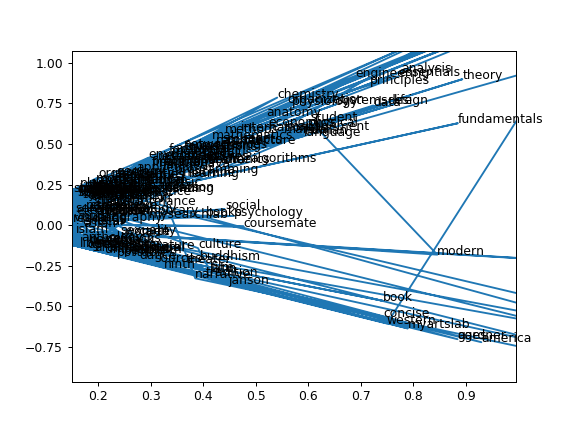

In [74]:
"""
Do the SVD
"""
from sklearn import decomposition # on my computer if you dont do this, it says sklearn does not have decompostion
svd = sklearn.decomposition.TruncatedSVD()
Z = svd.fit_transform(X)
print Z.shape # see the shape of the transformed words
plt.plot(Z[:,0],Z[:,1]) # plot the first 2 dimensions of all the words
for w in word_index_map:
    i = word_index_map[w]
    plt.annotate(w,xy=(Z[i,0],Z[i,1]))
